### Hyperparameters and Performance

In this project, I used 4 hyperparameters and their performance. Firstly, I created lists of the different options of hyperparameters, randomly sample from those lists and train a Keras model on Fashion - MNIST.
** I trained at least 10 different models

In [ ]:
lr = (0.1, 0.01)
bs = (1,127)
opt = ['adam'...]


In [ ]:
pip install keras-tuner

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
import kerastuner as kt
import matplotlib.pyplot as plt
import random

<ipython-input-3-d1a17a6b7e19>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Mount to Google Drive so I can save the hyperparameter optimization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
hyp_dir = '/content/drive/MyDrive/Data_Science_Machine_Learning/Wk_3/hyp_tuning'

I will consider the following hyperparameters: ***Number of layers, Number of Units per Layer, Activation Function, Optimizer***



4422102/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Train: X=(10000, 28, 28), y=(10000,)


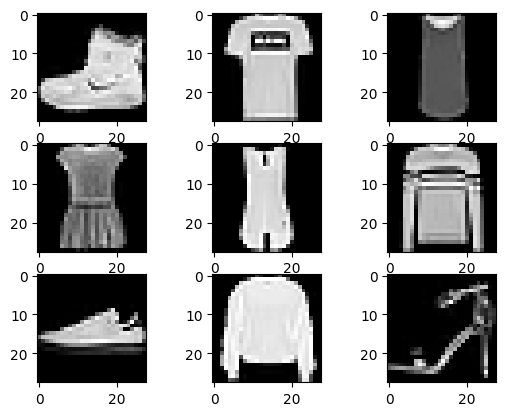

In [6]:
# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#summarize the dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Train: X=%s, y=%s' % (x_test.shape, y_test.shape))

#Let's plot the first few images
for i in range(9):
  #define subplot
  plt.subplot(330 + 1 + i)
  #plot raw pixel
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

#show the plot
plt.show()



In [7]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Let's define a function to Create and Compile the Model



In [9]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the number of layers
    num_layers = hp.Int('num_layers', min_value=2, max_value=4)
    for i in range(num_layers):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                        activation=hp.Choice('activation', ['relu', 'sigmoid'])))

    model.add(Dense(10, activation='softmax'))

    # Tune the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'RMSprop'])
    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'RMSprop':
        opt = RMSprop()

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:

# Initialize the tuner
#please note: using T4 GPU, this took >1hr to run

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=hyp_dir, #please replace this with "hyp_dir" (with quotation) to save it in colab & not to encounter error (I saved mine in Googledrive)
    project_name='fashion_mnist_tuning'
)


# Run the hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Trial 50 Complete [00h 01m 24s]
val_accuracy: 0.8716999888420105

Best val_accuracy So Far: 0.8907999992370605
Total elapsed time: 01h 02m 48s


In [11]:
# Get the best 10 hyperparameter sets
best_hps = tuner.oracle.get_best_trials(num_trials=10)

In [12]:
# Train 10 models with the extracted hyperparameters

histories = []
for i, trial in enumerate(best_hps):
    hp = trial.hyperparameters
    model = tuner.hypermodel.build(hp)

    print(f'Training model {i+1} with hyperparameters:')
    print(f'  num_layers: {hp.get("num_layers")}')
    for layer in range(hp.get("num_layers")):
        print(f'  units_{layer}: {hp.get(f"units_{layer}")}')
    print(f'  activation: {hp.get("activation")}')
    print(f'  optimizer: {hp.get("optimizer")}')

    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
    histories.append(history)

Training model 1 with hyperparameters:
  num_layers: 2
  units_0: 96
  units_1: 128
  activation: relu
  optimizer: adam
Training model 2 with hyperparameters:
  num_layers: 4
  units_0: 128
  units_1: 32
  units_2: 128
  units_3: 32
  activation: relu
  optimizer: adam
Training model 3 with hyperparameters:
  num_layers: 3
  units_0: 128
  units_1: 96
  units_2: 128
  activation: relu
  optimizer: adam
Training model 4 with hyperparameters:
  num_layers: 3
  units_0: 128
  units_1: 64
  units_2: 64
  activation: relu
  optimizer: adam
Training model 5 with hyperparameters:
  num_layers: 2
  units_0: 64
  units_1: 64
  activation: relu
  optimizer: adam
Training model 6 with hyperparameters:
  num_layers: 2
  units_0: 128
  units_1: 64
  activation: sigmoid
  optimizer: adam
Training model 7 with hyperparameters:
  num_layers: 3
  units_0: 128
  units_1: 128
  units_2: 96
  activation: relu
  optimizer: adam
Training model 8 with hyperparameters:
  num_layers: 4
  units_0: 128
  units_

**Plot Loss and Accuracy Curves**

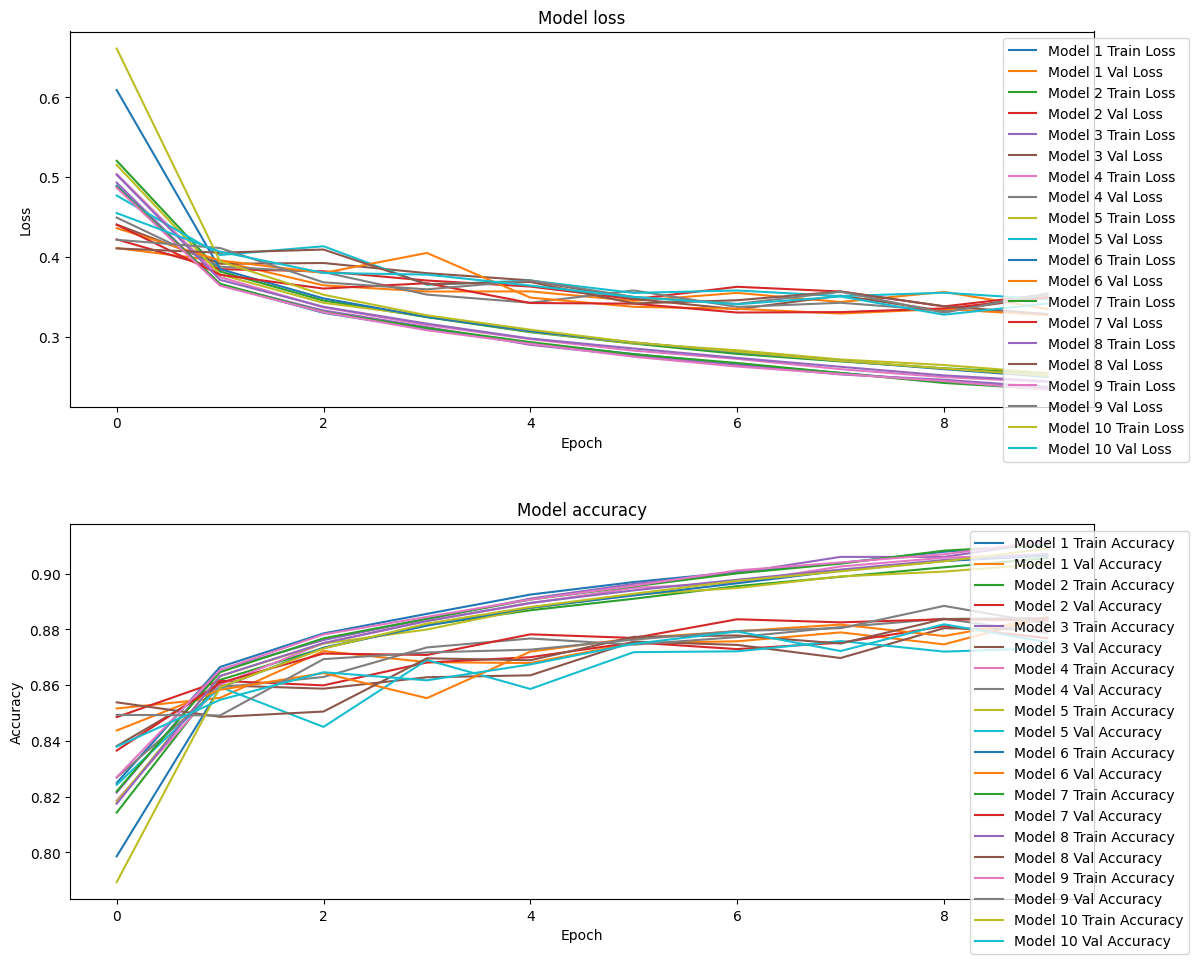

In [13]:
# Function to plot the loss and accuracy curves for multiple models
def plot_histories(histories):
    plt.figure(figsize=(12, 10))

    # Plot training & validation loss values
    plt.subplot(2, 1, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'Model {i+1} Train Loss')
        plt.plot(history.history['val_loss'], label=f'Model {i+1} Val Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'Model {i+1} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'Model {i+1} Val Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()

# Plot the results
plot_histories(histories)